<a href="https://colab.research.google.com/github/TrzeciakPiotr2300/Uczenie_Maszynowe_2025/blob/main/HW13_self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importy:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import numpy as np
import random
from tqdm import trange, tqdm


Funkcje i klasy:

In [3]:
# 1. Fixed function name (custom_set_seed -> set_seed)
def set_seed(seed=1):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Positional Encoding
class PositionalEncoding(nn.Module):
    # 2. Fixed special method name (custom___init__ -> __init__)
    def __init__(self, dim, max_len):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # 3. Use register_buffer for persistence

    # 4. Fixed method name (custom_forward -> forward)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Self-Attention with Dropout
class SelfAttention(nn.Module):
    # 5. Fixed special method name
    def __init__(self, d_model, k=8, dropout=0.1):  # 6. Fixed parameter name (d_detector_model -> d_model)
        super().__init__()
        self.q_proj = nn.Linear(d_model, k)
        self.k_proj = nn.Linear(d_model, k)
        self.v_proj = nn.Linear(d_model, d_model)
        self.scale = math.sqrt(k)
        self.dropout = nn.Dropout(dropout)

    # 7. Fixed method name
    def forward(self, x):
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)
        attn = torch.bmm(Q, K.transpose(1, 2)) / self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        return torch.bmm(attn, V)

# Main Model
class OddShapeDetector(nn.Module):
    # 8. Fixed special method name
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten(2)
        self.transpose = lambda x: x.transpose(1, 2)
        self.pos_enc = PositionalEncoding(dim=16, max_len=256)

        self.norm1 = nn.LayerNorm(16)
        self.attn = SelfAttention(d_model=16, k=8, dropout=0.1)  # 9. Fixed parameter name
        self.norm2 = nn.LayerNorm(16)

        self.cls_head = nn.Sequential(
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 1)
        )
        self.offset_head = nn.Sequential(
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 2)
        )

        self.register_buffer("grid_centers", self._make_centers())  # 10. Fixed method name

    # 11. Fixed method name (custom__make_centers -> _make_centers)
    def _make_centers(self):
        coords = torch.linspace(2, 62, 16)
        grid_y, grid_x = torch.meshgrid(coords, coords, indexing='ij')
        centers = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2)
        return centers

    # 12. Fixed method name
    def forward(self, x):
        B = x.size(0)
        feats = self.cnn(x)
        feats = self.flatten(feats)
        feats = self.transpose(feats)
        feats = self.pos_enc(feats)
        feats = self.norm1(feats)
        attended = self.attn(feats)
        attended = self.norm2(attended)

        logits = self.cls_head(attended).squeeze(-1)
        probs = F.softmax(logits, dim=-1)
        offsets = self.offset_head(attended)

        # 13. Fixed broadcasting: (256, 2) -> (1, 256, 2)
        centers_expanded = self.grid_centers.unsqueeze(0).expand(B, -1, -1)
        pred = (probs.unsqueeze(-1) * (centers_expanded + offsets)).sum(dim=1)
        return pred, probs


_____________________________________
#1. Architektura sieci
_____________________________________
1. **Wejście**  
   Sieć przyjmuje obrazy w odcieniach szarości o wymiarach 64×64 pikseli, reprezentowane jako tensor o kształcie **(B, 1, 64, 64)**, gdzie B to liczność partii (batch size). Każdy piksel jest znormalizowany do zakresu [0, 1], co stabilizuje proces uczenia i pozwala uniknąć problemów z różnymi skalami wartości.

2. **Bloki konwolucyjne (CNN)**  
   Pierwsza warstwa konwolucyjna transformuje wejście z 1 kanału do 16 kanałów, stosując filtr 5×5, krok (stride) równy 4 i dopełnienie (padding) 2. Dzięki temu rozdzielczość przestrzenna obrazu redukuje się z 64×64 do 16×16, a filtr o większym polu recepcyjnym umożliwia wychwycenie większych struktur. Po każdej konwolucji stosowana jest funkcja aktywacji ReLU, wprowadzająca nieliniowość. Druga warstwa, z filtrami 3×3 i paddingiem 1, utrzymuje rozmiar 16×16, ale umożliwia głębsze kodowanie cech lokalnych poprzez dodatkową konwolucję w obrębie już zredukowanej siatki.

3. **Transformacja do sekwencji cech**  
   Po przetworzeniu przez bloki CNN uzyskujemy tensor **(B, 16, 16, 16)**. Następnie stosujemy spłaszczanie wzdłuż dwóch ostatnich wymiarów (Flatten), przekształcając go w **(B, 16, 256)**. Kolejna transpozycja zamienia osie, tak by otrzymać **(B, 256, 16)** – 256 elementów sekwencji, z których każdy jest 16-wymiarowym wektorem cech odpowiadającym jednemu „patchowi” 16×16 w oryginalnym obrazie.

4. **Kodowanie pozycyjne**  
   Aby sieć wiedziała, która pozycja w sekwencji odpowiada której części obrazu, do wektorów cech dodawane jest kodowanie pozycyjne o wymiarze **(1, 256, 16)**. Dla każdej z 256 pozycji generowane są unikalne wzorce sinusoidalne i kosinusoidalne, o skalowaniu bazującym na wykładniku logarytmu z 10000. Dzięki temu sieć zyskuje dostęp do informacji o bezwzględnej pozycji każdego wektora w siatce.

5. **Warstwa self-attention**  
   Model tworzy trzy projekcje każdego wektora cech: zapytań Q (16→8), kluczy K (16→8) i wartości V (16→16). Następnie oblicza macierz podobieństwa jako iloczyn Q·Kᵀ podzielony przez √8, a softmax normalizuje wyniki wzdłuż drugiego wymiaru, uzyskując wagi atencji. Dodatkowo stosowany jest dropout (0.1), by ograniczyć nadmierne dopasowanie. Na wejściu i wyjściu tej warstwy stosowana jest warstwa normalizująca LayerNorm, co poprawia stabilność uczenia.

6. **Głowy predykcyjne**  
   Każdy z 256 przetworzonych wektorów cech trafia teraz do dwóch niezależnych MLP:  
   - **cls_head**: MLP o architekturze 16→16 (ReLU)→dropout(0.1)→1, zwracające logit, który po softmaxie staje się wagą mówiącą, z jakim prawdopodobieństwem dany patch zawiera odstający kształt.  
   - **offset_head**: MLP 16→16 (ReLU)→dropout(0.1)→2, przewidujące przesunięcie (dx, dy) względem środka danego patcha. To przesunięcie pozwala doprecyzować położenie kształtu wewnątrz każdego subregionu.

7. **Siatka centrów (grid_centers)**  
   W buforze `grid_centers` przechowywana jest stała macierz o kształcie **(256, 2)**, zawierająca współrzędne środków każdego patcha w oryginalnym obrazie. Są one równomiernie rozmieszczone od 2 do 62 pikseli zarówno w osi x, jak i y, co wynika z faktu, że krok konwolucji wynosi 4 px. Dzięki temu znane jest wyjściowe odniesienie, do którego dodawane są przewidywane przesunięcia z `offset_head`.

8. **Łączenie wyników w predykcję**  
   Dla każdego z 256 patchy obliczamy jego przewidywane centrum, dodając wektor przesunięcia do odpowiadającego punktu z `grid_centers`. Następnie wykonywane jest *miękkie uśrednienie ważone*: każde takie przewidywane położenie mnożone jest przez odpowiadające mu prawdopodobieństwo z `cls_head`, a wyniki sumowane po wszystkich pozycjach. Otrzymujemy w ten sposób jedną, precyzyjną parę współrzędnych (x, y) wskazującą na położenie odstającego kształtu w całym obrazie.



In [4]:
IMAGE_SIZE = 64  # 14. Renamed to avoid conflict
SHAPES = ("circle", "square", "triangle")

# 15. Fixed function name (custom_draw_shape -> draw_shape)
def draw_shape(drawer, shape_type, center_x, center_y, radius):
    if shape_type == "circle":
        drawer.ellipse([center_x - radius, center_y - radius,
                        center_x + radius, center_y + radius], fill="black")
    elif shape_type == "square":
        drawer.rectangle([center_x - radius, center_y - radius,
                          center_x + radius, center_y + radius], fill="black")
    else:  # triangle
        drawer.polygon([
            (center_x, center_y - radius),
            (center_x - radius, center_y + radius),
            (center_x + radius, center_y + radius)
        ], fill="black")

class OddXYDataset(Dataset):
    # 16. Fixed special method name
    def __init__(self,
                 num_samples,
                 same_shape_count_range=(3, 6),
                 shape_radius_range=(4, 10)):
        self.num_samples = num_samples
        self.same_shape_count_range = same_shape_count_range
        self.radius_min, self.radius_max = shape_radius_range

    # 17. Fixed special method name
    def __len__(self):
        return self.num_samples

    # 18. Fixed special method name
    def __getitem__(self, idx):
        base_shape = random.choice(SHAPES)
        odd_shape = random.choice([s for s in SHAPES if s != base_shape])

        img = Image.new("L", (IMAGE_SIZE, IMAGE_SIZE), "white")
        drawer = ImageDraw.Draw(img)

        # 19. Fixed function call
        for _ in range(random.randint(*self.same_shape_count_range)):
            radius = random.randint(self.radius_min, self.radius_max)
            cx = random.randint(radius, IMAGE_SIZE - radius - 1)
            cy = random.randint(radius, IMAGE_SIZE - radius - 1)
            draw_shape(drawer, base_shape, cx, cy, radius)

        radius = random.randint(self.radius_min, self.radius_max)
        cx = random.randint(radius, IMAGE_SIZE - radius - 1)
        cy = random.randint(radius, IMAGE_SIZE - radius - 1)
        draw_shape(drawer, odd_shape, cx, cy, radius)

        img_tensor = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.
        label_tensor = torch.tensor([cx, cy], dtype=torch.float32)  # 20. Removed unnecessary float()
        return img_tensor, label_tensor

Funkcje do obliczania RMSE, trenowania i plotowania:

In [5]:
# 21. Fixed function name
def compute_rmse(preds, targets):
    return torch.sqrt(((preds - targets) ** 2).sum(dim=1)).mean().item()

# Training loop
# 22. Fixed function name (custom_fit_detector_model -> fit_detector_model)
def fit_detector_model(model, train_loader, epochs=100, base_lr=0.001, patience=10):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=4, min_lr=1e-6)

    loss_fn = nn.MSELoss()
    best_rmse = float("inf")
    train_hist = []
    patience_counter = 0

    for epoch in trange(epochs, desc="Training Progress", unit="epoch"):
        set_seed(42 + 100 * epoch)
        model.train()

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred, _ = model(xb)
            loss = loss_fn(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        train_rmse = evaluate_rmse(model, train_loader)
        train_hist.append(train_rmse)
        tqdm.write(f"Epoch {epoch+1}/{epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train RMSE: {train_rmse:.2f}")

        if train_rmse < best_rmse:
            best_rmse = train_rmse
            patience_counter = 0
            torch.save({'model': model.state_dict()}, "checkpoint.pt")
        else:
            patience_counter += 1
            tqdm.write(f"No improvement. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                tqdm.write("Early stopping")
                break

        scheduler.step(train_rmse)

    return train_hist

# 28. Fixed function name
def evaluate_rmse(model, loader):
    preds, targets = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out, _ = model(xb)
            preds.append(out)
            targets.append(yb)

    # 29. Fixed function name
    return compute_rmse(torch.cat(preds), torch.cat(targets))

# 30. Fixed function name
def plot_rmse(rmse_history):
    plt.plot(rmse_history, label='Train RMSE')
    plt.axhline(5.0, color='red', linestyle='--', label='Target RMSE=5.0')
    plt.axhline(3.0, color='blue', linestyle='--', label='Target RMSE=3.0')
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title("Training RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

I ostatecznie wywołanie funkcji:

Using device: cuda


Training Progress:   3%|▎         | 1/30 [00:07<03:32,  7.34s/epoch]

Epoch 1/30 | LR: 0.010000 | Train RMSE: 16.36


Training Progress:   7%|▋         | 2/30 [00:14<03:18,  7.09s/epoch]

Epoch 2/30 | LR: 0.010000 | Train RMSE: 14.40


Training Progress:  10%|█         | 3/30 [00:21<03:10,  7.06s/epoch]

Epoch 3/30 | LR: 0.010000 | Train RMSE: 13.61


Training Progress:  13%|█▎        | 4/30 [00:28<03:07,  7.20s/epoch]

Epoch 4/30 | LR: 0.010000 | Train RMSE: 12.84


Training Progress:  17%|█▋        | 5/30 [00:35<02:56,  7.04s/epoch]

Epoch 5/30 | LR: 0.010000 | Train RMSE: 11.72


Training Progress:  20%|██        | 6/30 [00:42<02:53,  7.21s/epoch]

Epoch 6/30 | LR: 0.010000 | Train RMSE: 9.22


Training Progress:  23%|██▎       | 7/30 [00:49<02:41,  7.03s/epoch]

Epoch 7/30 | LR: 0.010000 | Train RMSE: 6.40


Training Progress:  27%|██▋       | 8/30 [00:57<02:39,  7.24s/epoch]

Epoch 8/30 | LR: 0.010000 | Train RMSE: 5.62


Training Progress:  30%|███       | 9/30 [01:05<02:37,  7.49s/epoch]

Epoch 9/30 | LR: 0.010000 | Train RMSE: 4.68


Training Progress:  33%|███▎      | 10/30 [01:12<02:28,  7.42s/epoch]

Epoch 10/30 | LR: 0.010000 | Train RMSE: 4.65


Training Progress:  37%|███▋      | 11/30 [01:20<02:24,  7.59s/epoch]

Epoch 11/30 | LR: 0.010000 | Train RMSE: 4.05


Training Progress:  40%|████      | 12/30 [01:27<02:11,  7.28s/epoch]

Epoch 12/30 | LR: 0.010000 | Train RMSE: 4.20
No improvement. Patience: 1/10


Training Progress:  43%|████▎     | 13/30 [01:34<02:02,  7.22s/epoch]

Epoch 13/30 | LR: 0.010000 | Train RMSE: 3.71


Training Progress:  47%|████▋     | 14/30 [01:41<01:53,  7.08s/epoch]

Epoch 14/30 | LR: 0.010000 | Train RMSE: 3.96
No improvement. Patience: 1/10


Training Progress:  50%|█████     | 15/30 [01:47<01:44,  6.95s/epoch]

Epoch 15/30 | LR: 0.010000 | Train RMSE: 3.43


Training Progress:  53%|█████▎    | 16/30 [01:54<01:38,  7.00s/epoch]

Epoch 16/30 | LR: 0.010000 | Train RMSE: 3.78
No improvement. Patience: 1/10


Training Progress:  57%|█████▋    | 17/30 [02:01<01:28,  6.81s/epoch]

Epoch 17/30 | LR: 0.010000 | Train RMSE: 3.37


Training Progress:  60%|██████    | 18/30 [02:08<01:22,  6.88s/epoch]

Epoch 18/30 | LR: 0.010000 | Train RMSE: 3.59
No improvement. Patience: 1/10


Training Progress:  63%|██████▎   | 19/30 [02:14<01:14,  6.74s/epoch]

Epoch 19/30 | LR: 0.010000 | Train RMSE: 3.19


Training Progress:  67%|██████▋   | 20/30 [02:22<01:09,  6.98s/epoch]

Epoch 20/30 | LR: 0.010000 | Train RMSE: 3.40
No improvement. Patience: 1/10


Training Progress:  70%|███████   | 21/30 [02:29<01:02,  6.99s/epoch]

Epoch 21/30 | LR: 0.010000 | Train RMSE: 3.16


Training Progress:  73%|███████▎  | 22/30 [02:36<00:57,  7.24s/epoch]

Epoch 22/30 | LR: 0.010000 | Train RMSE: 3.18
No improvement. Patience: 1/10


Training Progress:  77%|███████▋  | 23/30 [02:45<00:52,  7.49s/epoch]

Epoch 23/30 | LR: 0.010000 | Train RMSE: 3.23
No improvement. Patience: 2/10


Training Progress:  80%|████████  | 24/30 [02:52<00:44,  7.40s/epoch]

Epoch 24/30 | LR: 0.010000 | Train RMSE: 3.11


Training Progress:  83%|████████▎ | 25/30 [03:00<00:37,  7.58s/epoch]

Epoch 25/30 | LR: 0.010000 | Train RMSE: 3.08


Training Progress:  87%|████████▋ | 26/30 [03:08<00:30,  7.71s/epoch]

Epoch 26/30 | LR: 0.010000 | Train RMSE: 3.32
No improvement. Patience: 1/10


Training Progress:  90%|█████████ | 27/30 [03:15<00:22,  7.51s/epoch]

Epoch 27/30 | LR: 0.010000 | Train RMSE: 2.84


Training Progress:  93%|█████████▎| 28/30 [03:23<00:15,  7.61s/epoch]

Epoch 28/30 | LR: 0.010000 | Train RMSE: 3.09
No improvement. Patience: 1/10


Training Progress:  97%|█████████▋| 29/30 [03:30<00:07,  7.47s/epoch]

Epoch 29/30 | LR: 0.010000 | Train RMSE: 3.02
No improvement. Patience: 2/10


Training Progress: 100%|██████████| 30/30 [03:37<00:00,  7.24s/epoch]


Epoch 30/30 | LR: 0.010000 | Train RMSE: 2.92
No improvement. Patience: 3/10


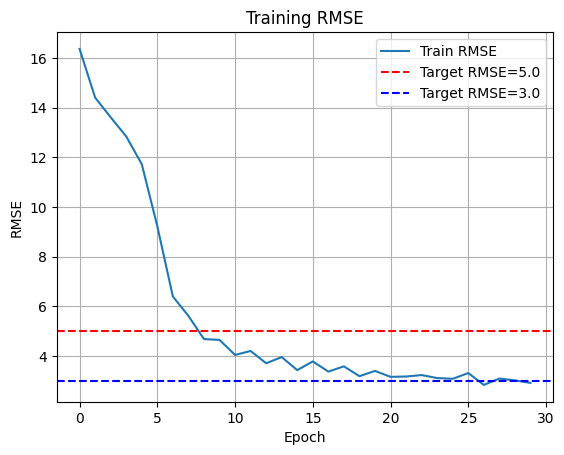

In [8]:
# Main execution
if __name__ == "__main__":
    set_seed(42)  # 31. Fixed function name
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_set = OddXYDataset(num_samples=25000)
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

    model = OddShapeDetector()
    rmse_history = fit_detector_model(  # 32. Fixed function name
        model,
        train_loader,
        epochs=30,
        base_lr=0.01
    )

    plot_rmse(rmse_history)  # 33. Fixed function name

Treningowe RMSE zeszło poniżej 3.0 (gdyby puścić więcej epok - schodzi jeszcze niżej, ale nie robię tego, bo już wyszło < 3.0, a może mi się skończyć GPU)

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch


def visualize_attention_triplet(model, dataset, idx):
    """
    Dla danego indeksu:
    - pokazuje obraz wejściowy z predykcją i GT
    - pokazuje attention heatmap (standardowa)
    - pokazuje attention heatmap (log skala)

    Obrazy prezentowane w 1 wierszu.
    """
    model.eval()
    img, label = dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred, _ = model(img_tensor)
        attn = model.attn.attn_weights.squeeze(0).detach().cpu().numpy()

    pred_np = pred.squeeze().cpu().numpy()
    img_np = img.squeeze().cpu().numpy()
    label_np = label.numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # === 1. Obraz wejściowy z GT i predykcja oraz współrzędne GT ===
    axes[0].imshow(img_np, cmap='gray')
    axes[0].scatter(*label_np, c='green', s=50, label='GT')
    axes[0].scatter(*pred_np, c='red', marker='x', s=50, label='Pred')
    # Dodanie tekstu z współrzędnymi GT
    x_gt, y_gt = label_np
    axes[0].text(
        x_gt, y_gt - 5,  # nieco nad punktem
        f"GT: ({x_gt:.1f}, {y_gt:.1f})",
        color='green', fontsize=10, fontweight='bold',
        ha='center', va='bottom'
    )
    axes[0].set_title(f"Sample {idx} | RMSE: {np.linalg.norm(label_np - pred_np):.2f}")
    axes[0].axis('off')
    axes[0].legend()

    # === 2. Standardowa heatmapa ===
    im1 = axes[1].imshow(attn, cmap='hot')
    axes[1].set_title("Attention Matrix")
    axes[1].set_xlabel("Key index")
    axes[1].set_ylabel("Query index")
    fig.colorbar(im1, ax=axes[1])

    # === 3. LogNorm heatmapa ===
    im2 = axes[2].imshow(attn, cmap='inferno', norm=LogNorm(vmin=attn.min()+1e-6, vmax=attn.max()))
    axes[2].set_title("LogNorm Attention")
    axes[2].set_xlabel("Key index")
    axes[2].set_ylabel("Query index")
    fig.colorbar(im2, ax=axes[2], label="log-scaled weight")

    plt.tight_layout()
    plt.show()


# === Uruchomienie ===
set_seed(234325352)
random.seed(234325352)
test_set = OddXYDataset(num_samples=25000)
indices_to_visualize = random.sample(range(len(test_set)), 20)
for idx in indices_to_visualize:
    visualize_attention_triplet(model, test_set, idx)

AttributeError: 'SelfAttention' object has no attribute 'attn_weights'